In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_predictions(results_df, ground_truth_df, label_column='label'):
    """Evaluate predictions against ground truth labels"""
    
    # Merge predictions with ground truth
    merged = results_df.copy()
    merged['true_label'] = ground_truth_df[label_column].values
    
    # DEBUG: Print what we're working with
    print("\nDEBUG INFO:")
    print(f"Predicted label sample: {merged['predicted_label'].head()}")
    print(f"Predicted label unique values: {merged['predicted_label'].unique()}")
    print(f"True label sample: {merged['true_label'].head()}")
    print(f"True label unique values: {merged['true_label'].unique()}")
    
    # Ensure both are numeric - CRITICAL FIX
    merged['predicted_numeric'] = pd.to_numeric(merged['predicted_label'], errors='coerce')
    merged['true_label_numeric'] = pd.to_numeric(merged['true_label'], errors='coerce')
    
    # Check for NaN values BEFORE filtering
    print(f"\nNaN in predictions: {merged['predicted_numeric'].isna().sum()}")
    print(f"NaN in true labels: {merged['true_label_numeric'].isna().sum()}")
    
    # Filter out errors (NaN from parsing failures) - MUST filter BOTH columns
    valid_mask = merged['predicted_numeric'].notna() & merged['true_label_numeric'].notna()
    valid_predictions = merged[valid_mask].copy()
    
    # NOW it's safe to convert to int
    valid_predictions['predicted_numeric'] = valid_predictions['predicted_numeric'].astype(int)
    valid_predictions['true_label_numeric'] = valid_predictions['true_label_numeric'].astype(int)
    
    error_count = len(merged) - len(valid_predictions)
    
    if error_count > 0:
        print(f"  Warning: {error_count} predictions had parsing errors and were excluded")
    
    # Get arrays for sklearn
    y_true = valid_predictions['true_label_numeric'].values
    y_pred = valid_predictions['predicted_numeric'].values
    
    print(f"\nFinal arrays for evaluation:")
    print(f"y_true: {y_true[:10]}")
    print(f"y_pred: {y_pred[:10]}")
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'total_samples': len(merged),
        'valid_predictions': len(valid_predictions),
        'parsing_errors': error_count,
        'true_positives': int(((y_pred == 1) & (y_true == 1)).sum()),
        'true_negatives': int(((y_pred == 0) & (y_true == 0)).sum()),
        'false_positives': int(((y_pred == 1) & (y_true == 0)).sum()),
        'false_negatives': int(((y_pred == 0) & (y_true == 1)).sum()),
    }
    
    return metrics, valid_predictions

In [ ]:
def print_metrics(metrics, approach_name):
    """Pretty print evaluation metrics"""
    print(f"\n{'='*70}")
    print(f"EVALUATION RESULTS: {approach_name}")
    print(f"{'='*70}")
    
    print(f"\n Overall Performance:")
    print(f"   Accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"   Precision: {metrics['precision']:.4f}")
    print(f"   Recall:    {metrics['recall']:.4f}")
    print(f"   F1-Score:  {metrics['f1_score']:.4f}")
    
    print(f"\ Sample Counts:")
    print(f"   Total samples:        {metrics['total_samples']}")
    print(f"   Valid predictions:    {metrics['valid_predictions']}")
    print(f"   Parsing errors:       {metrics['parsing_errors']}")
    
    print(f"\n Confusion Matrix Breakdown:")
    print(f"   True Positives (TP):  {metrics['true_positives']}  (Correctly identified burnout)")
    print(f"   True Negatives (TN):  {metrics['true_negatives']}  (Correctly identified no burnout)")
    print(f"   False Positives (FP): {metrics['false_positives']}  (Incorrectly labeled as burnout)")
    print(f"   False Negatives (FN): {metrics['false_negatives']}  (Missed burnout cases)")
    
    print(f"\n Confusion Matrix:")
    cm = metrics['confusion_matrix']
    print(f"                  Predicted No (0)  Predicted Yes (1)")
    print(f"   Actual No (0):        {cm[0][0]:4d}            {cm[0][1]:4d}")
    print(f"   Actual Yes (1):       {cm[1][0]:4d}            {cm[1][1]:4d}")
    
    print(f"{'='*70}\n")

In [ ]:
def plot_confusion_matrix(metrics, approach_name, save_path=None):
    """Plot confusion matrix as a heatmap"""
    cm = metrics['confusion_matrix']
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Burnout (0)', 'Burnout (1)'],
                yticklabels=['No Burnout (0)', 'Burnout (1)'],
                cbar_kws={'label': 'Count'})
    
    plt.title(f'Confusion Matrix: {approach_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f" Confusion matrix saved: {save_path}")
    
    plt.show()

In [ ]:
def analyze_errors(valid_predictions, text_column='text'):
    """Analyze misclassified examples"""
    
    # Find misclassifications
    errors = valid_predictions[valid_predictions['true_label_numeric'] != valid_predictions['predicted_numeric']].copy()
    
    print(f"\n{'='*70}")
    print(f"ERROR ANALYSIS")
    print(f"{'='*70}")
    print(f"Total misclassifications: {len(errors)}")
    
    if len(errors) == 0:
        print(" Perfect classification! No errors found.")
        return errors
    
    # False Positives (predicted burnout but actually not)
    false_positives = errors[errors['predicted_numeric'] == 1]
    print(f"\n False Positives: {len(false_positives)} (Predicted burnout, actually not)")
    
    # False Negatives (predicted not burnout but actually is)
    false_negatives = errors[errors['predicted_numeric'] == 0]
    print(f" False Negatives: {len(false_negatives)} (Missed burnout cases)")
    
    # Show a few examples
    print(f"\n Sample False Positives (first 3):")
    for idx, row in false_positives.head(3).iterrows():
        print(f"\n   Text: {row[text_column][:200]}...")
        print(f"   True: No Burnout (0) | Predicted: Burnout (1)")
        print(f"   Model output: {row['raw_output']}")
    
    print(f"\n Sample False Negatives (first 3):")
    for idx, row in false_negatives.head(3).iterrows():
        print(f"\n   Text: {row[text_column][:200]}...")
        print(f"   True: Burnout (1) | Predicted: No Burnout (0)")
        print(f"   Model output: {row['raw_output']}")
    
    return errors

Loading ground truth labels...
 Ground truth loaded: 167 samples

Loading prediction results...
 Results loaded: 167 samples

DEBUG INFO:
Predicted label sample: 0    0
1    0
2    0
3    1
4    0
Name: predicted_label, dtype: int64
Predicted label unique values: [0 1]
True label sample: 0    1
1    0
2    0
3    1
4    0
Name: true_label, dtype: int64
True label unique values: [1 0]

NaN in predictions: 0
NaN in true labels: 0

Final arrays for evaluation:
y_true: [1 0 0 1 0 1 0 1 0 0]
y_pred: [0 0 0 1 0 1 0 1 0 0]

EVALUATION RESULTS: Few-Shot_Claude-Sonnet

📊 Overall Performance:
   Accuracy:  0.7305 (73.05%)
   Precision: 0.3333
   Recall:    0.6071
   F1-Score:  0.4304

📈 Sample Counts:
   Total samples:        167
   Valid predictions:    167
   Parsing errors:       0

🎯 Confusion Matrix Breakdown:
   True Positives (TP):  17  (Correctly identified burnout)
   True Negatives (TN):  105  (Correctly identified no burnout)
   False Positives (FP): 34  (Incorrectly labeled as burnou

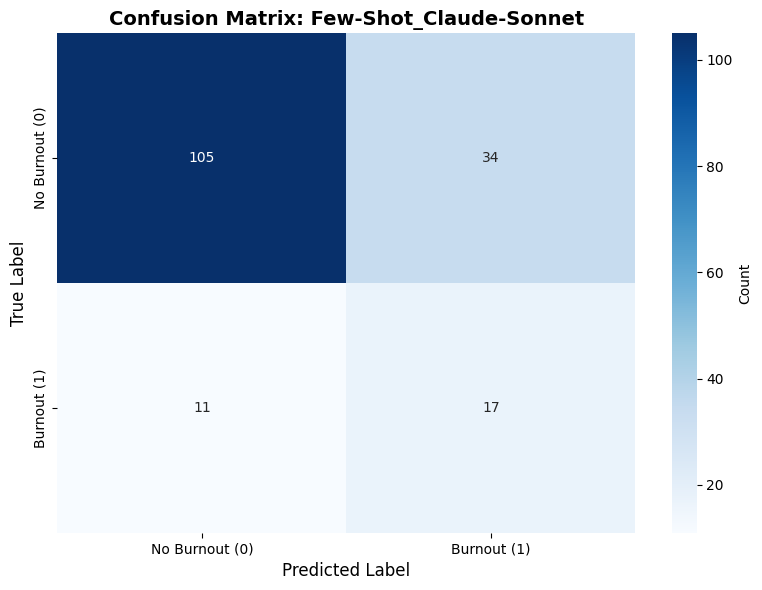


ERROR ANALYSIS
Total misclassifications: 45

 False Positives: 34 (Predicted burnout, actually not)
 False Negatives: 11 (Missed burnout cases)

 Sample False Positives (first 3):

   Text: If you could start fresh today as a do over, what would you do?
In this day and age how would y’all restart y’all’s career? Looking for tips 😅...
   True: No Burnout (0) | Predicted: Burnout (1)
   Model output: 0

The input is asking a hypothetical question about restarting careers and seeking general tips. The poster is not discussing their own current or past experience with work-related burnout or stress. This falls under the category of hypothetical situations that should not be labeled as 1, as specified in the instructions.

   Text: How do you de-stress?
My normal way to de-stress from work/life was to light up a bowl or from my pen but now that I’m seeing a few doors open in more serious security roles I gotta pass drug tests. A...
   True: No Burnout (0) | Predicted: Burnout (1)
   Model 

In [17]:
# ============================================================================
# MAIN EVALUATION - UPDATE FILE PATHS HERE
# ============================================================================

TEXT_COLUMN = 'text'  
LABEL_COLUMN = 'label' 

# CORRECTED FILE PATH - 
ground_truth_path = 'test_data_with_labels_BINARY.csv'
# results_path = 'results_Zero-Shot_Claude-Sonnet.csv'
results_path = 'results_Few-Shot_Claude-Sonnet_FIXED.csv'

# Load ground truth labels
print("Loading ground truth labels...")
ground_truth = pd.read_csv(ground_truth_path)
print(f" Ground truth loaded: {len(ground_truth)} samples")

# Load prediction results
print("\nLoading prediction results...")
results_df = pd.read_csv(results_path)
print(f" Results loaded: {len(results_df)} samples")

# Evaluate
metrics, valid_predictions = evaluate_predictions(results_df, ground_truth, LABEL_COLUMN)
approach_name = results_df['approach'].iloc[0] if 'approach' in results_df.columns else 'Single Approach'

# Print metrics
print_metrics(metrics, approach_name)

# Plot confusion matrix
plot_confusion_matrix(metrics, approach_name, save_path=f'confusion_matrix_{approach_name}.png')

# Analyze errors
errors = analyze_errors(valid_predictions, TEXT_COLUMN)

# Save error analysis
if len(errors) > 0:
    errors.to_csv(f'error_analysis_{approach_name}.csv', index=False)
    print(f"\n Error analysis saved: error_analysis_{approach_name}.csv")

In [ ]:
# import pandas as pd

# # ============================================================================
# # FIX THE -1 VALUE IN FEW-SHOT RESULTS
# # ============================================================================

# fewshot_path = 'results_Few-Shot_Claude-Sonnet.csv'

# print("="*70)
# print("FIXING FEW-SHOT RESULTS")
# print("="*70)

# # Load the results
# results_df = pd.read_csv(fewshot_path)

# print(f"\nBefore fix:")
# print(results_df['predicted_label'].value_counts().sort_index())

# # Find the -1 prediction
# error_row = results_df[results_df['predicted_label'] == -1]
# print(f"\nFound {len(error_row)} prediction(s) with value -1")

# if len(error_row) > 0:
#     print("\nError row details:")
#     for idx, row in error_row.iterrows():
#         print(f"  Text: {row['text'][:150]}...")
#         print(f"  Raw output: {row['raw_output']}")
#         print(f"  Current predicted_label: {row['predicted_label']}")
    
#     # Strategy: Look at the raw output and try to extract 0 or 1
#     # If we can't find it, default to 0 (no burnout) as the conservative choice
    
#     def reparse_output(output):
#         """Try to extract 0 or 1 from the output"""
#         output_str = str(output).strip().lower()
        
#         # Check if output contains reasoning about burnout
#         burnout_keywords = ['burnout', 'stress', 'experiencing', 'discussing their own']
#         no_burnout_keywords = ['not discussing', 'advice', 'guidance', 'hypothetical', 'others']
        
#         # Count keywords
#         burnout_count = sum(1 for kw in burnout_keywords if kw in output_str)
#         no_burnout_count = sum(1 for kw in no_burnout_keywords if kw in output_str)
        
#         # Look for explicit 0 or 1
#         if "1" in output_str:
#             return 1
#         elif "0" in output_str:
#             return 0
#         # If no explicit answer but we can infer from keywords
#         elif 'advice' in output_str or 'guidance' in output_str or 'others' in output_str:
#             return 0  # Likely advising others, not personal burnout
#         else:
#             # Conservative default: no burnout
#             return 0
    
#     # Apply the fix
#     results_df.loc[results_df['predicted_label'] == -1, 'predicted_label'] = \
#         results_df.loc[results_df['predicted_label'] == -1, 'raw_output'].apply(reparse_output)
    
#     print(f"\nAfter reparsing:")
#     print(f"  Fixed -1 value to: {results_df.loc[error_row.index[0], 'predicted_label']}")

# print(f"\nAfter fix:")
# print(results_df['predicted_label'].value_counts().sort_index())

# # Verify no -1 values remain
# if -1 in results_df['predicted_label'].values:
#     print("\n Warning: Still have -1 values!")
# else:
#     print("\n All -1 values fixed!")

# # Save the fixed file
# output_path = fewshot_path.replace('.csv', '_FIXED.csv')
# results_df.to_csv(output_path, index=False)

# print(f"\n" + "="*70)
# print("SAVED")
# print("="*70)
# print(f"Fixed results saved to:")
# print(f"  {output_path}")
# print(f"\nYou can now use this file for evaluation!")

# # Also update the original file if you want
# print(f"\nDo you want to overwrite the original file? (y/n)")
# print(f"If yes, manually rename {output_path}")
# print(f"to {fewshot_path}")

FIXING FEW-SHOT RESULTS

Before fix:
predicted_label
-1      1
 0    115
 1     51
Name: count, dtype: int64

Found 1 prediction(s) with value -1

Error row details:
  Text: Dealing with feeling stuck in the security field
### Opening Statement

In argument theory, there's a concept of a false dichotomy. Within a false dic...
  Raw output: Looking at this input text, I need to determine if the poster is discussing their own work-related burnout/stress in the past or present.

The poster is writing an advice/guidance post for others who might be feeling "stuck in the security field." While they mention burnout as a concept and acknowledge that workplaces aren't perfect ("sunshine and rainbows"), they are not discussing their own personal experience with burnout or work-related stress.

Key indicators this is NOT
  Current predicted_label: -1

After reparsing:
  Fixed -1 value to: 0

After fix:
predicted_label
0    116
1     51
Name: count, dtype: int64

 All -1 values fixed!

SAVED
Fixe